In [2]:
import pandas as pd
import numpy as np
import os

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
file_path = "/Users/wangshuaibo/Library/CloudStorage/OneDrive-bsu.edu.cn/Archive/文件_XsensMVN输出文档/XsensMTw_ExampleData.txt"

In [4]:
df = pd.read_csv(file_path,skiprows=12,sep="\t")
df.columns

Index(['PacketCounter', 'Year', 'Month', 'Day', 'Second', 'UTC_Nano',
       'UTC_Year', 'UTC_Month', 'UTC_Day', 'UTC_Hour', 'UTC_Minute',
       'UTC_Second', 'UTC_Valid', 'Acc_X', 'Acc_Y', 'Acc_Z', 'FreeAcc_E',
       'FreeAcc_N', 'FreeAcc_U', 'AccHR_X', 'AccHR_Y', 'AccHR_Z', 'Gyr_X',
       'Gyr_Y', 'Gyr_Z', 'GyrHR_X', 'GyrHR_Y', 'GyrHR_Z', 'Mag_X', 'Mag_Y',
       'Mag_Z', 'VelInc_X', 'VelInc_Y', 'VelInc_Z', 'OriInc_q0', 'OriInc_q1',
       'OriInc_q2', 'OriInc_q3', 'Quat_q0', 'Quat_q1', 'Quat_q2', 'Quat_q3',
       'Roll', 'Pitch', 'Yaw', 'Mat[1][1]', 'Mat[2][1]', 'Mat[3][1]',
       'Mat[1][2]', 'Mat[2][2]', 'Mat[3][2]', 'Mat[1][3]', 'Mat[2][3]',
       'Mat[3][3]', 'Latitude', 'Longitude', 'Altitude', 'Vel_E', 'Vel_N',
       'Vel_U', 'GyrTemp_X', 'GyrTemp_Y', 'GyrTemp_Z'],
      dtype='object')

## 欧拉角转为旋转矩阵

In [109]:
from numpy import cos as cos
from numpy import sin as sin
def euler2matrix(phi,theta,psi):
    '''
    功能：
    根据欧拉角计算旋转矩阵

    参数：
    phi: 围绕 X 轴旋转的角度
    theta: 围绕 Y 轴旋转角度
    psi: 围绕 Z 轴旋转角度
    单位为 度

    返回: 
    旋转矩阵
    旋转矩阵的顺序为：mat11,mat12,mat13, mat21, mat22, mat23, mat31,mat32,mat33
    '''
    phi_rad = np.deg2rad(phi)
    theta_rad = np.deg2rad(theta)
    psi_rad = np.deg2rad(psi)

    mat11 = cos(theta_rad)*cos(psi_rad)
    mat12 = sin(phi_rad)*sin(theta_rad)*cos(psi_rad) - cos(phi_rad)*sin(psi_rad)
    mat13 = cos(phi_rad)*sin(theta_rad)*cos(psi_rad) + sin(phi_rad)*sin(psi_rad)

    mat21 = cos(theta_rad)*sin(psi_rad)
    mat22 = sin(phi_rad)*sin(theta_rad)*sin(psi_rad) + cos(phi_rad)*cos(psi_rad)
    mat23 = cos(phi_rad)*sin(theta_rad)*sin(psi_rad) - sin(phi_rad)*cos(psi_rad)

    mat31 = -sin(theta_rad)
    mat32 = sin(phi_rad)*cos(theta_rad)
    mat33 = cos(phi_rad)*cos(theta_rad) 

    matrix = np.array([mat11,mat12,mat13,
             mat21, mat22, mat23,
             mat31,mat32,mat33])
    return matrix

In [110]:
matrix_xsens = ['Mat[1][1]','Mat[1][2]','Mat[1][3]',
                'Mat[2][1]','Mat[2][2]','Mat[2][3]',
                'Mat[3][1]','Mat[3][2]','Mat[3][3]']
euler_xsens = ['Roll', 'Pitch', 'Yaw']
free_acc_xsens = ['FreeAcc_E','FreeAcc_N', 'FreeAcc_U']

<Axes: >

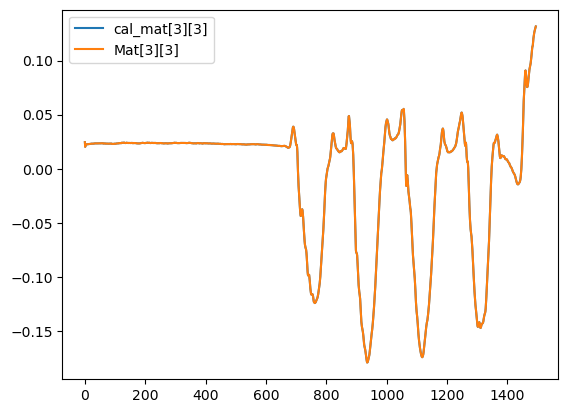

In [111]:
cal_matrixs = []
for i,row in df.iterrows():
    matrix = euler2matrix(row["Roll"],row["Pitch"],row["Yaw"])
    cal_matrixs.append(matrix)
cal_mat_name = ['cal_mat[1][1]','cal_mat[1][2]','cal_mat[1][3]',
            'cal_mat[2][1]','cal_mat[2][2]','cal_mat[2][3]',
            'cal_mat[3][1]','cal_mat[3][2]','cal_mat[3][3]']
df[cal_mat_name] = pd.DataFrame(cal_matrixs)
df[['cal_mat[3][3]','Mat[3][3]']].plot()

In [113]:
# 向量化操作优化操作
roll = df["Roll"].values
pitch = df["Pitch"].values
yaw = df["Yaw"].values
cal_matrix = euler2matrix(roll,pitch,yaw)
# 使用 Zip 可以简化多个 for 循环操作
#cal_matrixs = [euler2matrix(r, p, y) for r, p, y in zip(roll, pitch, yaw)]
cal_matrix.shape

(9, 1495)

## 计算自由加速度

验证结果：通过✅
计算得到的自由加速度与Xsens 加速度略有差异。
根据 Xsens Dot 可知，Xsens 对直接计算的结果进行了滤波处理。


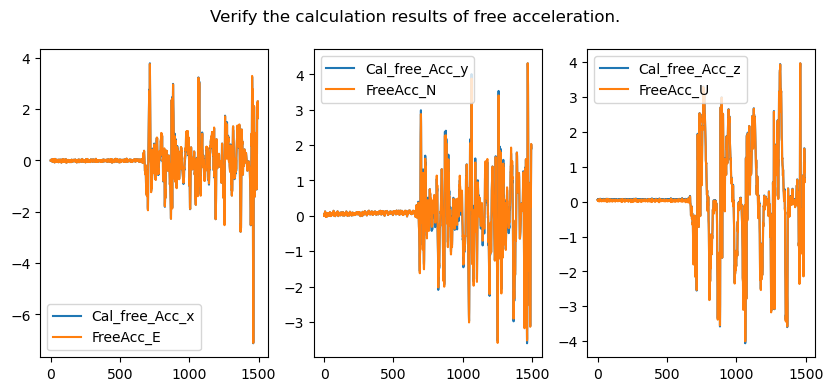

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 假设 df 是一个包含所需数据的 DataFrame

# 将变量定义为numpy数组 并重置为 row，3，3 的数组
# reshpe(-1,3,3) 中-1 表示自动计算 df 的行数
matrix = df[["Mat[1][1]","Mat[1][2]","Mat[1][3]",
              "Mat[2][1]","Mat[2][2]","Mat[2][3]",
              "Mat[3][1]","Mat[3][2]","Mat[3][3]"]].values.reshape(-1, 3, 3)

Acc = df[["Acc_X","Acc_Y","Acc_Z"]].values
g = 9.8

# 定义自由加速度函数
def calFreeAcc(matrix, Acc, g=9.8):
    # 1. 将传感器加速度转换到大地坐标系
    # 多维array 使用 dot 会错误local_acc_transformed = np.dot(matrix, Acc)
    #local_acc_transformed = np.array([np.dot(matrix[i], Acc[i]) for i in range(len(matrix))])
    # 下面的方式是张量的方式, 详情参见：https://chat.forefront.ai/share/nh863emygn3vu312
    local_acc_transformed = np.einsum('ijk,ik->ij', matrix, Acc)
    # 2. 去除重力
    free_acc = local_acc_transformed - np.array([0,0,g])
    return free_acc

# 进行计算
free_acc_transformed = calFreeAcc(matrix, Acc)

# 将计算结果存储在numpy数组中
cal_free_acc = free_acc_transformed
# 将计算结果赋值给DataFrame中的新列
df[["Cal_free_Acc_x","Cal_free_Acc_y","Cal_free_Acc_z"]] = cal_free_acc


# 同时绘制Xsens 自由加速度以及计算得到的加速度
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(10,4))
plt.suptitle("Verify the calculation results of free acceleration.")
df[["Cal_free_Acc_x","FreeAcc_E"]].plot(ax=axs[0])
df[["Cal_free_Acc_y","FreeAcc_N"]].plot(ax=axs[1])
df[["Cal_free_Acc_z","FreeAcc_U"]].plot(ax=axs[2])

print("验证结果：通过✅")
print("计算得到的自由加速度与Xsens 加速度略有差异。\n"
      "根据 Xsens Dot 可知，Xsens 对直接计算的结果进行了滤波处理。")


# 尝试批量计算四元数

In [33]:
import pandas as pd
import numpy as np
from pyquaternion import Quaternion

df = pd.DataFrame({"roll":[30,60,90],
                   "pitch":[40,70,100],
                   "yaw":[50,70,110]
})

from scipy.spatial.transform import Rotation as R
# 使用列表接受元素
quaternions = []
for i,row in df.iterrows():
    r = R.from_euler("zyx", [row['roll'], row['pitch'],row['yaw']],degrees=True )
    # 将数组转化成列表
    rotation = r.as_quat().tolist()  
    quaternions.append(rotation)
# 将列表转换为 DataFrame               
df[["q1","q2","q3","q0"]] = pd.DataFrame(quaternions)
df[["q1","q2","q3","q0"]]

,q1,q2,q3,q0
0,0.463827,0.196628,0.360042,0.785221
1,0.641822,0.171976,0.620419,0.416617
2,0.683013,-0.061628,0.704416,-0.183013


In [115]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R

# 定义函数，将欧拉角转换为四元数
def euler_to_quaternion(row):
    r = R.from_euler("zyx", [row['roll'], row['pitch'], row['yaw']], degrees=True)
    return r.as_quat()

# 创建示例 DataFrame
df = pd.DataFrame({"roll": [30, 60, 90], "pitch": [40, 70, 100], "yaw": [50, 70, 110]})

# 使用 apply() 方法将欧拉角转换为四元数，并将结果添加到 DataFrame 中
df[['q1', 'q2', 'q3', 'q0']] = df.apply(euler_to_quaternion, axis=1, result_type='expand')

# 输出结果
print(df)

   roll  pitch  yaw        q1        q2        q3        q0
0    30     40   50  0.463827  0.196628  0.360042  0.785221
1    60     70   70  0.641822  0.171976  0.620419  0.416617
2    90    100  110  0.683013 -0.061628  0.704416 -0.183013
